In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import jabble.dataset
import jabble.loss
import jabble.model
import os

import matplotlib.pyplot as plt
from matplotlib import cm

<h1>32 - Take data from MANY straight flying star</h1>

In [2]:
from datetime import datetime
import os
date = datetime.today().strftime('%Y-%m-%d')
outdir = os.path.join('/scratch/mdd423/simulacra/out/',date)
os.makedirs(outdir,exist_ok=True)

In [3]:
import glob
files = glob.glob('/scratch/mdd423/simulacra/out/2022-03-21/data_*')
# import os
# mypath = '/scratch/mdd423/simulacra/out/2022-03-07/'
# files = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f)) and "8.3e+03" in f]

In [4]:
files

['/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr67.3.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr6.1.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr98.0.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr116.3.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr36.7.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr159.2.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr85.7.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr49.0.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr12.2.h5',
 '/scratch/mdd423/simulacra/out/2022-03-21/data_e30_R130000.0_a10.0_p30.

In [5]:
import scipy.ndimage
def normalize(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low

In [6]:
# datasets = []
# h5_data = []
# snrs = []
for file in files[:1]:
    data    = simulacra.dataset.from_h5(file)
#     h5_data.append(data)
    epoches = data['data']['flux'].shape[0]

    wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
    flux = np.array(data['data']['flux'])
    ferr = np.array(data['data']['ferr'])

    masks = np.array(data['data']['mask'],dtype=bool)
    masks = np.logical_or(np.isnan(ferr), masks)
    masks = np.logical_or(np.isnan(flux), masks)
    masks = np.logical_or(flux <= 0, masks)

    sigma = 110
    dataset = jabble.dataset.Dataset.from_flux(wave,flux,ferr,masks,normalize,nargs=[sigma])
#     dataset.set_mask(0.0,10.0)
    
#     datasets.append(dataset)

    obs_times = data['data']['obs_times']
    times = at.Time(obs_times)

    loc    = data['parameters']['detector']['loc']
    target = data['parameters']['star']['target']
    resolution = float(data['parameters']['detector']['_resolution'][()])

    bc = target.radial_velocity_correction(obstime=times[-1],location=loc).to(u.km/u.s)
    rv = data['data']['rvs'].to(u.km/u.s)
    snr = np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])])
#     snrs.append(snr)
#     print(snr)

<HDF5 dataset "obs_times": shape (30,), type "|O">


/home/mdd423/wobble_jax/notebooks/../jabble/dataset.py:122: RuntimeWarning: invalid value encountered in true_divide
  ys = np.log(flux_interp/flux_norm)
/home/mdd423/wobble_jax/notebooks/../jabble/dataset.py:122: RuntimeWarning: divide by zero encountered in log
  ys = np.log(flux_interp/flux_norm)


<h2>Load Data</h2>
Load in the datasets and normalize it using a gaussian filter. And take a look at slices of each dataset. Each dataset read in has a different average SNR across all epoches. We will fit a model to each dataset and compare the accuracy of the radial velocity as function of this SNR.

In [7]:
def normal_flux(y,sigma=100):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low

<h2>Mask ends</h2>
Mask off the ends of the dataset with a padding larger than any possible velocity shift.

<h2>Definitions</h2>
Define our loss function, Chi Square, Models, and Initial Values.

In [8]:
loss = jabble.loss.ChiSquare()
init_vels = np.linspace(-300,300,epoches) * u.km/u.s
init_shifts = jabble.dataset.shifts(init_vels)

In [9]:
def train_cycle(model,data,loss,fit1_inds):
    model.fix()
    for ind in fit1_inds:
        model.fit(*ind)
    res1 = model.optimize(loss,data,margs={'iprint':1,'ftol':1e-23,'maxls':256,'eps':1e-12},save_history=False)
    model.fix()
    return model

<h2>Round 1</h2>
Fit the flux control points to the data using the train cycle described!

<h2>Round 2</h2>
now fitting both the flux control points and red shifts!

In [10]:
ind1 = [[1]]
ind2 = [[0],[1]]

final_vels = np.zeros((len(files),epoches)) * u.km/u.s
snrs       = []
for i,file in enumerate(files):
    data    = simulacra.dataset.from_h5(file)
    snr = np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])])
    snrs.append(snr)
    
    epoches = data['data']['flux'].shape[0]

    wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
    flux = np.array(data['data']['flux'])
    ferr = np.array(data['data']['ferr'])

    masks = np.array(data['data']['mask'],dtype=bool)
    masks = np.logical_or(np.isnan(ferr), masks)
    masks = np.logical_or(np.isnan(flux), masks)
    masks = np.logical_or(flux <= 0, masks)

    sigma = 110
    dataset = jabble.dataset.Dataset.from_flux(wave,flux,ferr,masks,normalize,nargs=[sigma])
    x_min = np.min(dataset.xs)
    x_max = np.max(dataset.xs)
    max_vel = 600 * u.km/u.s
    padding = jabble.dataset.shifts(max_vel)
    
    dataset.mask[dataset.xs < x_min + padding] = 1
    dataset.mask[dataset.xs > x_max - padding] = 1
    dataset.set_mask(0.0,10.0)
    
    vel_padding = 4 * u.km/u.s
    resolution = float(data['parameters']['detector']['_resolution'][()])
    x_grid = jabble.model.create_x_grid(dataset.xs,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
    
    model = jabble.model.stellar_model(init_shifts,x_grid)
    model = train_cycle(model,dataset,loss,ind1)
    model = train_cycle(model,dataset,loss,ind2)
    filename = 'jab_model_snr_{}.png'.format(snr)
    jabble.model.save(os.path.join(outdir,filename),model)
#     models.append(model)
    
    final_vels[i,:] = jabble.dataset.velocities(model[0].p)

<HDF5 dataset "obs_times": shape (30,), type "|O">


2022-03-24 11:22:05.521908: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-03-24 11:22:05.521937: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08194D+08    |proj g|=  2.27592D+05


 This problem is unconstrained.



At iterate    1    f=  8.46715D+07    |proj g|=  1.79282D+05

At iterate    2    f=  6.60178D+07    |proj g|=  9.47934D+04

At iterate    3    f=  6.52465D+07    |proj g|=  7.80786D+04

At iterate    4    f=  6.47772D+07    |proj g|=  4.83155D+04

At iterate    5    f=  6.46296D+07    |proj g|=  3.50785D+04

At iterate    6    f=  6.45591D+07    |proj g|=  2.93893D+04

At iterate    7    f=  6.45206D+07    |proj g|=  2.04878D+04

At iterate    8    f=  6.45063D+07    |proj g|=  1.36042D+04

At iterate    9    f=  6.44999D+07    |proj g|=  6.08898D+03

At iterate   10    f=  6.44963D+07    |proj g|=  5.37997D+03

At iterate   11    f=  6.44953D+07    |proj g|=  4.93282D+03

At iterate   12    f=  6.44943D+07    |proj g|=  2.53034D+03

At iterate   13    f=  6.44940D+07    |proj g|=  1.54317D+03

At iterate   14    f=  6.44939D+07    |proj g|=  1.15646D+03

At iterate   15    f=  6.44938D+07    |proj g|=  9.68627D+02

At iterate   16    f=  6.44937D+07    |proj g|=  7.91762D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   23    f=  6.44936D+07    |proj g|=  2.59537D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     23     46      1     0     0   2.595D+02   6.449D+07
  F =   64493608.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46253D+07    |proj g|=  1.66384D+11


 This problem is unconstrained.



At iterate    1    f=  5.72356D+07    |proj g|=  6.80639D+10

At iterate    2    f=  5.56873D+07    |proj g|=  1.36360D+10

At iterate    3    f=  5.56841D+07    |proj g|=  1.45163D+10

At iterate    4    f=  5.56825D+07    |proj g|=  1.28277D+10

At iterate    5    f=  5.56808D+07    |proj g|=  1.36360D+10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    6    f=  5.56808D+07    |proj g|=  1.36360D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      6     34      1     0     0   1.364D+10   5.568D+07
  F =   55680796.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29911D+06    |proj g|=  1.91257D+03


 This problem is unconstrained.



At iterate    1    f=  4.05481D+06    |proj g|=  1.54951D+03

At iterate    2    f=  3.79477D+06    |proj g|=  8.30177D+02

At iterate    3    f=  3.78344D+06    |proj g|=  6.24686D+02

At iterate    4    f=  3.77800D+06    |proj g|=  3.97731D+02

At iterate    5    f=  3.77656D+06    |proj g|=  2.90939D+02

At iterate    6    f=  3.77567D+06    |proj g|=  2.69090D+02

At iterate    7    f=  3.77511D+06    |proj g|=  2.12533D+02

At iterate    8    f=  3.77483D+06    |proj g|=  1.56491D+02

At iterate    9    f=  3.77478D+06    |proj g|=  2.20984D+02

At iterate   10    f=  3.77458D+06    |proj g|=  6.64175D+01

At iterate   11    f=  3.77456D+06    |proj g|=  5.25369D+01

At iterate   12    f=  3.77454D+06    |proj g|=  4.09445D+01

At iterate   13    f=  3.77453D+06    |proj g|=  3.12334D+01

At iterate   14    f=  3.77453D+06    |proj g|=  1.56294D+01

At iterate   15    f=  3.77452D+06    |proj g|=  1.38741D+01

At iterate   16    f=  3.77452D+06    |proj g|=  1.65355D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77923D+06    |proj g|=  5.99432D+08


 This problem is unconstrained.



At iterate    1    f=  3.77923D+06    |proj g|=  5.99432D+08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     30      1     0     0   5.994D+08   3.779D+06
  F =   3779225.2500000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25129D+08    |proj g|=  5.10317D+05


 This problem is unconstrained.



At iterate    1    f=  1.69658D+08    |proj g|=  3.98251D+05

At iterate    2    f=  1.12592D+08    |proj g|=  2.10760D+05

At iterate    3    f=  1.10212D+08    |proj g|=  1.64417D+05

At iterate    4    f=  1.08972D+08    |proj g|=  1.07579D+05

At iterate    5    f=  1.08514D+08    |proj g|=  8.37385D+04

At iterate    6    f=  1.08278D+08    |proj g|=  6.61629D+04

At iterate    7    f=  1.08152D+08    |proj g|=  4.46972D+04

At iterate    8    f=  1.08100D+08    |proj g|=  3.09543D+04

At iterate    9    f=  1.08074D+08    |proj g|=  2.26912D+04

At iterate   10    f=  1.08063D+08    |proj g|=  1.58248D+04

At iterate   11    f=  1.08057D+08    |proj g|=  1.26877D+04

At iterate   12    f=  1.08054D+08    |proj g|=  5.09883D+03

At iterate   13    f=  1.08052D+08    |proj g|=  3.52022D+03

At iterate   14    f=  1.08052D+08    |proj g|=  2.93307D+03

At iterate   15    f=  1.08051D+08    |proj g|=  4.60300D+03

At iterate   16    f=  1.08051D+08    |proj g|=  1.64773D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   23    f=  1.08051D+08    |proj g|=  5.79919D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     23     48      1     0     0   5.799D+02   1.081D+08
  F =   108050928.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08167D+08    |proj g|=  4.92239D+10


 This problem is unconstrained.



At iterate    1    f=  1.08126D+08    |proj g|=  5.01907D+10

At iterate    2    f=  1.08103D+08    |proj g|=  3.92746D+10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    3    f=  1.08103D+08    |proj g|=  3.92746D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      3     29      1     0     0   3.927D+10   1.081D+08
  F =   108103496.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16057D+08    |proj g|=  7.25701D+05


 This problem is unconstrained.



At iterate    1    f=  2.37828D+08    |proj g|=  5.66198D+05

At iterate    2    f=  1.57291D+08    |proj g|=  2.96739D+05

At iterate    3    f=  1.53931D+08    |proj g|=  2.31239D+05

At iterate    4    f=  1.52184D+08    |proj g|=  1.51404D+05

At iterate    5    f=  1.51537D+08    |proj g|=  1.17185D+05

At iterate    6    f=  1.51202D+08    |proj g|=  9.17696D+04

At iterate    7    f=  1.51026D+08    |proj g|=  6.28639D+04

At iterate    8    f=  1.50954D+08    |proj g|=  4.46451D+04

At iterate    9    f=  1.50918D+08    |proj g|=  3.37046D+04

At iterate   10    f=  1.50901D+08    |proj g|=  2.41086D+04

At iterate   11    f=  1.50893D+08    |proj g|=  1.51722D+04

At iterate   12    f=  1.50889D+08    |proj g|=  9.10582D+03

At iterate   13    f=  1.50887D+08    |proj g|=  7.00978D+03

At iterate   14    f=  1.50886D+08    |proj g|=  4.83138D+03

At iterate   15    f=  1.50885D+08    |proj g|=  4.90092D+03

At iterate   16    f=  1.50885D+08    |proj g|=  2.26238D+03

At iter

 This problem is unconstrained.



At iterate    1    f=  1.51066D+08    |proj g|=  5.67887D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     30      1     0     0   5.679D+10   1.511D+08
  F =   151066464.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46111D+07    |proj g|=  7.23251D+04


 This problem is unconstrained.



At iterate    1    f=  2.67925D+07    |proj g|=  5.64976D+04

At iterate    2    f=  1.87413D+07    |proj g|=  2.94982D+04

At iterate    3    f=  1.84054D+07    |proj g|=  2.30353D+04

At iterate    4    f=  1.82311D+07    |proj g|=  1.51211D+04

At iterate    5    f=  1.81666D+07    |proj g|=  1.16603D+04

At iterate    6    f=  1.81334D+07    |proj g|=  9.20555D+03

At iterate    7    f=  1.81155D+07    |proj g|=  6.30703D+03

At iterate    8    f=  1.81082D+07    |proj g|=  4.48364D+03

At iterate    9    f=  1.81046D+07    |proj g|=  3.44873D+03

At iterate   10    f=  1.81029D+07    |proj g|=  2.49535D+03

At iterate   11    f=  1.81021D+07    |proj g|=  1.71185D+03

At iterate   12    f=  1.81016D+07    |proj g|=  9.81347D+02

At iterate   13    f=  1.81014D+07    |proj g|=  7.70136D+02

At iterate   14    f=  1.81014D+07    |proj g|=  5.62934D+02

At iterate   15    f=  1.81013D+07    |proj g|=  6.13598D+02

At iterate   16    f=  1.81013D+07    |proj g|=  2.74546D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   23    f=  1.81012D+07    |proj g|=  7.01533D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     23     39      1     0     0   7.015D+01   1.810D+07
  F =   18101246.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81235D+07    |proj g|=  6.09253D+09


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  1.81235D+07    |proj g|=  6.09253D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     32      1     0     0   6.093D+09   1.812D+07
  F =   18123510.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88733D+08    |proj g|=  1.35903D+06


 This problem is unconstrained.



At iterate    1    f=  4.42265D+08    |proj g|=  1.06051D+06

At iterate    2    f=  2.91512D+08    |proj g|=  5.54730D+05

At iterate    3    f=  2.85226D+08    |proj g|=  4.33143D+05

At iterate    4    f=  2.81956D+08    |proj g|=  2.84253D+05

At iterate    5    f=  2.80742D+08    |proj g|=  2.19419D+05

At iterate    6    f=  2.80113D+08    |proj g|=  1.71688D+05

At iterate    7    f=  2.79782D+08    |proj g|=  1.17353D+05

At iterate    8    f=  2.79645D+08    |proj g|=  8.32752D+04

At iterate    9    f=  2.79578D+08    |proj g|=  6.29221D+04

At iterate   10    f=  2.79547D+08    |proj g|=  4.50255D+04

At iterate   11    f=  2.79532D+08    |proj g|=  2.82137D+04

At iterate   12    f=  2.79523D+08    |proj g|=  1.67136D+04

At iterate   13    f=  2.79520D+08    |proj g|=  1.28540D+04

At iterate   14    f=  2.79518D+08    |proj g|=  8.87330D+03

At iterate   15    f=  2.79517D+08    |proj g|=  9.33780D+03

At iterate   16    f=  2.79517D+08    |proj g|=  4.02886D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   24    f=  2.79516D+08    |proj g|=  1.28175D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     24     44      1     0     0   1.282D+03   2.795D+08
  F =   279516128.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79845D+08    |proj g|=  1.04819D+11


 This problem is unconstrained.



At iterate    1    f=  2.79845D+08    |proj g|=  1.04819D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     30      1     0     0   1.048D+11   2.798D+08
  F =   279844736.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73126D+08    |proj g|=  3.94000D+05


 This problem is unconstrained.



At iterate    1    f=  1.30648D+08    |proj g|=  3.07320D+05

At iterate    2    f=  8.69333D+07    |proj g|=  1.60791D+05

At iterate    3    f=  8.51115D+07    |proj g|=  1.25532D+05

At iterate    4    f=  8.41638D+07    |proj g|=  8.22494D+04

At iterate    5    f=  8.38120D+07    |proj g|=  6.36010D+04

At iterate    6    f=  8.36298D+07    |proj g|=  4.97721D+04

At iterate    7    f=  8.35340D+07    |proj g|=  3.40132D+04

At iterate    8    f=  8.34945D+07    |proj g|=  2.41369D+04

At iterate    9    f=  8.34752D+07    |proj g|=  1.82295D+04

At iterate   10    f=  8.34662D+07    |proj g|=  1.29922D+04

At iterate   11    f=  8.34617D+07    |proj g|=  8.10912D+03

At iterate   12    f=  8.34592D+07    |proj g|=  4.79007D+03

At iterate   13    f=  8.34582D+07    |proj g|=  3.65297D+03

At iterate   14    f=  8.34576D+07    |proj g|=  2.48964D+03

At iterate   15    f=  8.34574D+07    |proj g|=  2.64296D+03

At iterate   16    f=  8.34573D+07    |proj g|=  1.18442D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   26    f=  8.34571D+07    |proj g|=  2.26709D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     26     43      1     0     0   2.267D+02   8.346D+07
  F =   83457104.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35563D+07    |proj g|=  3.11402D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  8.35563D+07    |proj g|=  3.11402D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     27      1     0     0   3.114D+10   8.356D+07
  F =   83556272.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88793D+07    |proj g|=  1.28588D+05


 This problem is unconstrained.



At iterate    1    f=  4.49920D+07    |proj g|=  1.00412D+05

At iterate    2    f=  3.06936D+07    |proj g|=  5.25946D+04

At iterate    3    f=  3.00980D+07    |proj g|=  4.09214D+04

At iterate    4    f=  2.97886D+07    |proj g|=  2.70126D+04

At iterate    5    f=  2.96737D+07    |proj g|=  2.08138D+04

At iterate    6    f=  2.96141D+07    |proj g|=  1.62877D+04

At iterate    7    f=  2.95822D+07    |proj g|=  1.10546D+04

At iterate    8    f=  2.95691D+07    |proj g|=  7.78658D+03

At iterate    9    f=  2.95628D+07    |proj g|=  5.89821D+03

At iterate   10    f=  2.95597D+07    |proj g|=  4.17876D+03

At iterate   11    f=  2.95583D+07    |proj g|=  2.99171D+03

At iterate   12    f=  2.95574D+07    |proj g|=  1.49731D+03

At iterate   13    f=  2.95571D+07    |proj g|=  1.13112D+03

At iterate   14    f=  2.95569D+07    |proj g|=  7.93732D+02

At iterate   15    f=  2.95568D+07    |proj g|=  1.06158D+03

At iterate   16    f=  2.95568D+07    |proj g|=  3.86591D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   24    f=  2.95567D+07    |proj g|=  2.47688D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     24     41      1     0     0   2.477D+02   2.956D+07
  F =   29556716.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95913D+07    |proj g|=  1.01610D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  2.95913D+07    |proj g|=  1.01610D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     28      1     0     0   1.016D+10   2.959D+07
  F =   29591252.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91419D+06    |proj g|=  7.95422D+03


 This problem is unconstrained.



At iterate    1    f=  6.02582D+06    |proj g|=  6.24543D+03

At iterate    2    f=  5.10518D+06    |proj g|=  3.31384D+03

At iterate    3    f=  5.06653D+06    |proj g|=  2.54940D+03

At iterate    4    f=  5.04712D+06    |proj g|=  1.65699D+03

At iterate    5    f=  5.04004D+06    |proj g|=  1.26676D+03

At iterate    6    f=  5.03659D+06    |proj g|=  1.04805D+03

At iterate    7    f=  5.03428D+06    |proj g|=  7.00842D+02

At iterate    8    f=  5.03349D+06    |proj g|=  5.41882D+02

At iterate    9    f=  5.03307D+06    |proj g|=  3.96248D+02

At iterate   10    f=  5.03286D+06    |proj g|=  2.92487D+02

At iterate   11    f=  5.03276D+06    |proj g|=  2.08294D+02

At iterate   12    f=  5.03270D+06    |proj g|=  1.77161D+02

At iterate   13    f=  5.03267D+06    |proj g|=  7.32012D+01

At iterate   14    f=  5.03266D+06    |proj g|=  7.36049D+01

At iterate   15    f=  5.03265D+06    |proj g|=  5.23961D+01

At iterate   16    f=  5.03265D+06    |proj g|=  1.18580D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   23    f=  5.03264D+06    |proj g|=  1.22310D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     23     40      1     0     0   1.223D+01   5.033D+06
  F =   5032642.5000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03911D+06    |proj g|=  1.00084D+09


 This problem is unconstrained.



At iterate    1    f=  5.03911D+06    |proj g|=  1.00084D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     31      1     0     0   1.001D+09   5.039D+06
  F =   5039106.0000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36117D+07    |proj g|=  1.62607D+05


 This problem is unconstrained.



At iterate    1    f=  5.60431D+07    |proj g|=  1.26826D+05

At iterate    2    f=  3.79517D+07    |proj g|=  6.65161D+04

At iterate    3    f=  3.71966D+07    |proj g|=  5.18955D+04

At iterate    4    f=  3.68042D+07    |proj g|=  3.39884D+04

At iterate    5    f=  3.66590D+07    |proj g|=  2.62372D+04

At iterate    6    f=  3.65842D+07    |proj g|=  2.06382D+04

At iterate    7    f=  3.65446D+07    |proj g|=  1.41369D+04

At iterate    8    f=  3.65283D+07    |proj g|=  1.00308D+04

At iterate    9    f=  3.65203D+07    |proj g|=  7.59939D+03

At iterate   10    f=  3.65166D+07    |proj g|=  5.43361D+03

At iterate   11    f=  3.65147D+07    |proj g|=  3.42407D+03

At iterate   12    f=  3.65137D+07    |proj g|=  2.00803D+03

At iterate   13    f=  3.65132D+07    |proj g|=  1.53505D+03

At iterate   14    f=  3.65130D+07    |proj g|=  1.06783D+03

At iterate   15    f=  3.65129D+07    |proj g|=  8.88365D+02

At iterate   16    f=  3.65129D+07    |proj g|=  4.80007D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   22    f=  3.65128D+07    |proj g|=  2.29654D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     22     40      1     0     0   2.297D+02   3.651D+07
  F =   36512808.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65578D+07    |proj g|=  1.29613D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  3.65578D+07    |proj g|=  1.29613D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     32      1     0     0   1.296D+10   3.656D+07
  F =   36557780.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34723D+08    |proj g|=  1.46550D+06


 This problem is unconstrained.



At iterate    1    f=  4.76769D+08    |proj g|=  1.14328D+06

At iterate    2    f=  3.14177D+08    |proj g|=  5.98759D+05

At iterate    3    f=  3.07395D+08    |proj g|=  4.66950D+05

At iterate    4    f=  3.03867D+08    |proj g|=  3.06527D+05

At iterate    5    f=  3.02558D+08    |proj g|=  2.36558D+05

At iterate    6    f=  3.01880D+08    |proj g|=  1.85273D+05

At iterate    8    f=  3.01376D+08    |proj g|=  9.00627D+04

At iterate    9    f=  3.01304D+08    |proj g|=  6.80747D+04

At iterate   10    f=  3.01270D+08    |proj g|=  4.87499D+04

At iterate   11    f=  3.01254D+08    |proj g|=  3.06230D+04

At iterate   12    f=  3.01244D+08    |proj g|=  1.81914D+04

At iterate   13    f=  3.01240D+08    |proj g|=  1.39616D+04

At iterate   14    f=  3.01238D+08    |proj g|=  9.61094D+03

At iterate   15    f=  3.01238D+08    |proj g|=  9.94904D+03

At iterate   16    f=  3.01237D+08    |proj g|=  4.40697D+03

At iterate   17    f=  3.01237D+08    |proj g|=  3.88388D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   21    f=  3.01237D+08    |proj g|=  2.35850D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     21     37      1     0     0   2.358D+03   3.012D+08
  F =   301236576.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01594D+08    |proj g|=  1.12934D+11


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  3.01594D+08    |proj g|=  1.12934D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     31      1     0     0   1.129D+11   3.016D+08
  F =   301593920.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61457D+08    |proj g|=  1.06358D+06


 This problem is unconstrained.



At iterate    1    f=  3.46844D+08    |proj g|=  8.30268D+05

At iterate    2    f=  2.28888D+08    |proj g|=  4.34361D+05

At iterate    3    f=  2.23968D+08    |proj g|=  3.38928D+05

At iterate    4    f=  2.21409D+08    |proj g|=  2.22359D+05

At iterate    5    f=  2.20461D+08    |proj g|=  1.71635D+05

At iterate    6    f=  2.19970D+08    |proj g|=  1.34397D+05

At iterate    7    f=  2.19712D+08    |proj g|=  9.18794D+04

At iterate    8    f=  2.19605D+08    |proj g|=  6.51664D+04

At iterate    9    f=  2.19553D+08    |proj g|=  4.92298D+04

At iterate   10    f=  2.19529D+08    |proj g|=  3.52361D+04

At iterate   11    f=  2.19517D+08    |proj g|=  2.21278D+04

At iterate   12    f=  2.19510D+08    |proj g|=  1.31183D+04

At iterate   13    f=  2.19508D+08    |proj g|=  1.00973D+04

At iterate   14    f=  2.19506D+08    |proj g|=  6.98529D+03

At iterate   15    f=  2.19506D+08    |proj g|=  7.30875D+03

At iterate   16    f=  2.19505D+08    |proj g|=  3.15436D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   26    f=  2.19505D+08    |proj g|=  5.94022D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     26     54      1     0     0   5.940D+02   2.195D+08
  F =   219504896.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19765D+08    |proj g|=  8.14665D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  2.19765D+08    |proj g|=  8.14665D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     28      1     0     0   8.147D+10   2.198D+08
  F =   219765040.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49790D+08    |proj g|=  3.39604D+05


 This problem is unconstrained.



At iterate    1    f=  1.13158D+08    |proj g|=  2.64957D+05

At iterate    2    f=  7.54488D+07    |proj g|=  1.38860D+05

At iterate    3    f=  7.38775D+07    |proj g|=  1.08312D+05

At iterate    4    f=  7.30606D+07    |proj g|=  7.09872D+04

At iterate    5    f=  7.27577D+07    |proj g|=  5.48865D+04

At iterate    6    f=  7.26007D+07    |proj g|=  4.29708D+04

At iterate    7    f=  7.25180D+07    |proj g|=  2.93816D+04

At iterate    8    f=  7.24839D+07    |proj g|=  2.08722D+04

At iterate    9    f=  7.24673D+07    |proj g|=  1.58245D+04

At iterate   10    f=  7.24595D+07    |proj g|=  1.13067D+04

At iterate   11    f=  7.24556D+07    |proj g|=  7.06664D+03

At iterate   12    f=  7.24534D+07    |proj g|=  4.18879D+03

At iterate   13    f=  7.24526D+07    |proj g|=  3.24100D+03

At iterate   14    f=  7.24521D+07    |proj g|=  2.24771D+03

At iterate   15    f=  7.24519D+07    |proj g|=  2.45026D+03

At iterate   16    f=  7.24518D+07    |proj g|=  1.02164D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25408D+07    |proj g|=  2.68183D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  7.25408D+07    |proj g|=  2.68183D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     25      1     0     0   2.682D+10   7.254D+07
  F =   72540808.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82739D+08    |proj g|=  1.80930D+06


 This problem is unconstrained.



At iterate    1    f=  5.87736D+08    |proj g|=  1.41170D+06

At iterate    2    f=  3.87012D+08    |proj g|=  7.39548D+05

At iterate    3    f=  3.78640D+08    |proj g|=  5.76591D+05

At iterate    4    f=  3.74283D+08    |proj g|=  3.78155D+05

At iterate    5    f=  3.72667D+08    |proj g|=  2.91742D+05

At iterate    6    f=  3.71829D+08    |proj g|=  2.28221D+05

At iterate    7    f=  3.71390D+08    |proj g|=  1.55795D+05

At iterate    8    f=  3.71209D+08    |proj g|=  1.10440D+05

At iterate    9    f=  3.71120D+08    |proj g|=  8.33809D+04

At iterate   10    f=  3.71080D+08    |proj g|=  5.96303D+04

At iterate   11    f=  3.71059D+08    |proj g|=  3.73949D+04

At iterate   12    f=  3.71048D+08    |proj g|=  2.22183D+04

At iterate   13    f=  3.71043D+08    |proj g|=  1.71088D+04

At iterate   14    f=  3.71041D+08    |proj g|=  1.18067D+04

At iterate   15    f=  3.71040D+08    |proj g|=  1.25211D+04

At iterate   16    f=  3.71039D+08    |proj g|=  5.39011D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   27    f=  3.71039D+08    |proj g|=  1.49076D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     27     53      1     0     0   1.491D+03   3.710D+08
  F =   371038592.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71477D+08    |proj g|=  1.39418D+11


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  3.71477D+08    |proj g|=  1.39418D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     31      1     0     0   1.394D+11   3.715D+08
  F =   371476768.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02123D+08    |proj g|=  1.15789D+06


 This problem is unconstrained.



At iterate    1    f=  3.77326D+08    |proj g|=  9.03451D+05

At iterate    2    f=  2.48891D+08    |proj g|=  4.73019D+05

At iterate    3    f=  2.43534D+08    |proj g|=  3.69111D+05

At iterate    4    f=  2.40745D+08    |proj g|=  2.42123D+05

At iterate    5    f=  2.39711D+08    |proj g|=  1.86842D+05

At iterate    6    f=  2.39174D+08    |proj g|=  1.46214D+05

At iterate    7    f=  2.38892D+08    |proj g|=  9.99119D+04

At iterate    8    f=  2.38776D+08    |proj g|=  7.09071D+04

At iterate    9    f=  2.38719D+08    |proj g|=  5.35415D+04

At iterate   10    f=  2.38693D+08    |proj g|=  3.82185D+04

At iterate   11    f=  2.38680D+08    |proj g|=  2.39035D+04

At iterate   12    f=  2.38672D+08    |proj g|=  1.42180D+04

At iterate   13    f=  2.38669D+08    |proj g|=  1.08885D+04

At iterate   14    f=  2.38668D+08    |proj g|=  7.42654D+03

At iterate   15    f=  2.38667D+08    |proj g|=  8.41305D+03

At iterate   16    f=  2.38667D+08    |proj g|=  3.42260D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38948D+08    |proj g|=  8.90315D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  2.38948D+08    |proj g|=  8.90315D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     31      1     0     0   8.903D+10   2.389D+08
  F =   238948224.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53687D+08    |proj g|=  5.80632D+05


 This problem is unconstrained.



At iterate    1    f=  1.91053D+08    |proj g|=  4.52694D+05

At iterate    2    f=  1.26581D+08    |proj g|=  2.37381D+05

At iterate    3    f=  1.23894D+08    |proj g|=  1.85168D+05

At iterate    4    f=  1.22496D+08    |proj g|=  1.21525D+05

At iterate    5    f=  1.21977D+08    |proj g|=  9.36968D+04

At iterate    6    f=  1.21708D+08    |proj g|=  7.32660D+04

At iterate    7    f=  1.21567D+08    |proj g|=  4.99511D+04

At iterate    8    f=  1.21509D+08    |proj g|=  3.53652D+04

At iterate    9    f=  1.21480D+08    |proj g|=  2.66693D+04

At iterate   10    f=  1.21467D+08    |proj g|=  1.90007D+04

At iterate   11    f=  1.21461D+08    |proj g|=  1.18378D+04

At iterate   12    f=  1.21457D+08    |proj g|=  6.95752D+03

At iterate   13    f=  1.21455D+08    |proj g|=  5.32370D+03

At iterate   14    f=  1.21455D+08    |proj g|=  3.64574D+03

At iterate   15    f=  1.21454D+08    |proj g|=  4.11883D+03

At iterate   16    f=  1.21454D+08    |proj g|=  1.67549D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   21    f=  1.21454D+08    |proj g|=  9.40496D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     21     39      1     0     0   9.405D+02   1.215D+08
  F =   121453968.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21596D+08    |proj g|=  4.49160D+10


 This problem is unconstrained.



At iterate    1    f=  1.21596D+08    |proj g|=  4.49160D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     28      1     0     0   4.492D+10   1.216D+08
  F =   121596352.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98261D+08    |proj g|=  4.52216D+05


 This problem is unconstrained.



At iterate    1    f=  1.49500D+08    |proj g|=  3.52806D+05

At iterate    2    f=  9.93124D+07    |proj g|=  1.84901D+05

At iterate    3    f=  9.72195D+07    |proj g|=  1.44090D+05

At iterate    4    f=  9.61304D+07    |proj g|=  9.45381D+04

At iterate    5    f=  9.57262D+07    |proj g|=  7.29968D+04

At iterate    6    f=  9.55167D+07    |proj g|=  5.69929D+04

At iterate    7    f=  9.54065D+07    |proj g|=  3.87837D+04

At iterate    8    f=  9.53611D+07    |proj g|=  2.74272D+04

At iterate    9    f=  9.53391D+07    |proj g|=  2.07055D+04

At iterate   10    f=  9.53289D+07    |proj g|=  1.47455D+04

At iterate   11    f=  9.53238D+07    |proj g|=  9.18767D+03

At iterate   12    f=  9.53210D+07    |proj g|=  5.40361D+03

At iterate   13    f=  9.53198D+07    |proj g|=  4.13945D+03

At iterate   14    f=  9.53192D+07    |proj g|=  2.84654D+03

At iterate   15    f=  9.53190D+07    |proj g|=  3.08134D+03

At iterate   16    f=  9.53188D+07    |proj g|=  1.28693D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54331D+07    |proj g|=  3.50775D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  9.54331D+07    |proj g|=  3.50775D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     32      1     0     0   3.508D+10   9.543D+07
  F =   95433088.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31582D+08    |proj g|=  1.69072D+06


 This problem is unconstrained.



At iterate    1    f=  5.49372D+08    |proj g|=  1.31905D+06

At iterate    2    f=  3.61828D+08    |proj g|=  6.90791D+05

At iterate    3    f=  3.54006D+08    |proj g|=  5.38721D+05

At iterate    4    f=  3.49938D+08    |proj g|=  3.53602D+05

At iterate    5    f=  3.48428D+08    |proj g|=  2.72903D+05

At iterate    6    f=  3.47647D+08    |proj g|=  2.13467D+05

At iterate    7    f=  3.47236D+08    |proj g|=  1.45804D+05

At iterate    8    f=  3.47066D+08    |proj g|=  1.03357D+05

At iterate    9    f=  3.46984D+08    |proj g|=  7.79290D+04

At iterate   10    f=  3.46945D+08    |proj g|=  5.55722D+04

At iterate   11    f=  3.46926D+08    |proj g|=  3.46779D+04

At iterate   12    f=  3.46915D+08    |proj g|=  2.05159D+04

At iterate   13    f=  3.46911D+08    |proj g|=  1.56857D+04

At iterate   14    f=  3.46909D+08    |proj g|=  1.06938D+04

At iterate   15    f=  3.46908D+08    |proj g|=  1.21144D+04

At iterate   16    f=  3.46907D+08    |proj g|=  4.91650D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  3.46906D+08    |proj g|=  1.30079D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     25     51      1     0     0   1.301D+03   3.469D+08
  F =   346906432.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47318D+08    |proj g|=  1.29766D+11


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  3.47318D+08    |proj g|=  1.29766D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     32      1     0     0   1.298D+11   3.473D+08
  F =   347318176.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49722D+08    |proj g|=  8.04210D+05


 This problem is unconstrained.



At iterate    1    f=  2.63047D+08    |proj g|=  6.27652D+05

At iterate    2    f=  1.73825D+08    |proj g|=  3.28456D+05

At iterate    3    f=  1.70102D+08    |proj g|=  2.56191D+05

At iterate    4    f=  1.68166D+08    |proj g|=  1.68206D+05

At iterate    5    f=  1.67448D+08    |proj g|=  1.29721D+05

At iterate    6    f=  1.67075D+08    |proj g|=  1.01440D+05

At iterate    7    f=  1.66879D+08    |proj g|=  6.91062D+04

At iterate    8    f=  1.66798D+08    |proj g|=  4.88022D+04

At iterate    9    f=  1.66759D+08    |proj g|=  3.67204D+04

At iterate   10    f=  1.66740D+08    |proj g|=  2.61717D+04

At iterate   11    f=  1.66731D+08    |proj g|=  1.63189D+04

At iterate   12    f=  1.66726D+08    |proj g|=  9.52639D+03

At iterate   13    f=  1.66724D+08    |proj g|=  7.25407D+03

At iterate   14    f=  1.66723D+08    |proj g|=  4.95224D+03

At iterate   15    f=  1.66722D+08    |proj g|=  5.59873D+03

At iterate   16    f=  1.66722D+08    |proj g|=  2.34434D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66922D+08    |proj g|=  6.18981D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  1.66922D+08    |proj g|=  6.18981D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     30      1     0     0   6.190D+10   1.669D+08
  F =   166921648.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00278D+07    |proj g|=  2.00910D+05


 This problem is unconstrained.



At iterate    1    f=  6.83454D+07    |proj g|=  1.56743D+05

At iterate    2    f=  4.60255D+07    |proj g|=  8.23577D+04

At iterate    3    f=  4.50942D+07    |proj g|=  6.40278D+04

At iterate    4    f=  4.46101D+07    |proj g|=  4.19508D+04

At iterate    5    f=  4.44308D+07    |proj g|=  3.24719D+04

At iterate    6    f=  4.43381D+07    |proj g|=  2.54516D+04

At iterate    7    f=  4.42889D+07    |proj g|=  1.73451D+04

At iterate    8    f=  4.42686D+07    |proj g|=  1.22238D+04

At iterate    9    f=  4.42586D+07    |proj g|=  9.18314D+03

At iterate   10    f=  4.42539D+07    |proj g|=  6.47994D+03

At iterate   11    f=  4.42516D+07    |proj g|=  3.97784D+03

At iterate   12    f=  4.42503D+07    |proj g|=  2.24741D+03

At iterate   13    f=  4.42498D+07    |proj g|=  1.66511D+03

At iterate   14    f=  4.42495D+07    |proj g|=  1.09009D+03

At iterate   15    f=  4.42493D+07    |proj g|=  1.42047D+03

At iterate   16    f=  4.42493D+07    |proj g|=  6.43859D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   23    f=  4.42492D+07    |proj g|=  2.63916D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     23     42      1     0     0   2.639D+02   4.425D+07
  F =   44249200.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43007D+07    |proj g|=  1.58150D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  4.43007D+07    |proj g|=  1.58150D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     31      1     0     0   1.582D+10   4.430D+07
  F =   44300712.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83967D+08    |proj g|=  6.51176D+05


 This problem is unconstrained.



At iterate    1    f=  2.13758D+08    |proj g|=  5.07975D+05

At iterate    2    f=  1.41493D+08    |proj g|=  2.66308D+05

At iterate    3    f=  1.38481D+08    |proj g|=  2.07631D+05

At iterate    4    f=  1.36913D+08    |proj g|=  1.36234D+05

At iterate    5    f=  1.36331D+08    |proj g|=  1.05209D+05

At iterate    6    f=  1.36030D+08    |proj g|=  8.24280D+04

At iterate    7    f=  1.35871D+08    |proj g|=  5.66100D+04

At iterate    8    f=  1.35806D+08    |proj g|=  4.03313D+04

At iterate    9    f=  1.35774D+08    |proj g|=  3.05215D+04

At iterate   10    f=  1.35759D+08    |proj g|=  2.19299D+04

At iterate   11    f=  1.35752D+08    |proj g|=  1.38668D+04

At iterate   12    f=  1.35747D+08    |proj g|=  8.30218D+03

At iterate   13    f=  1.35746D+08    |proj g|=  6.40137D+03

At iterate   14    f=  1.35745D+08    |proj g|=  4.45273D+03

At iterate   15    f=  1.35744D+08    |proj g|=  4.27704D+03

At iterate   16    f=  1.35744D+08    |proj g|=  2.08836D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   24    f=  1.35744D+08    |proj g|=  6.89881D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     24     44      1     0     0   6.899D+02   1.357D+08
  F =   135743920.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35907D+08    |proj g|=  5.02331D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  1.35907D+08    |proj g|=  5.02331D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     30      1     0     0   5.023D+10   1.359D+08
  F =   135906688.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22512D+08    |proj g|=  9.72855D+05


 This problem is unconstrained.



At iterate    1    f=  3.17648D+08    |proj g|=  7.58908D+05

At iterate    2    f=  2.09716D+08    |proj g|=  3.97131D+05

At iterate    3    f=  2.05214D+08    |proj g|=  3.10012D+05

At iterate    4    f=  2.02873D+08    |proj g|=  2.03279D+05

At iterate    5    f=  2.02005D+08    |proj g|=  1.57119D+05

At iterate    6    f=  2.01555D+08    |proj g|=  1.23118D+05

At iterate    7    f=  2.01318D+08    |proj g|=  8.42062D+04

At iterate    8    f=  2.01220D+08    |proj g|=  5.97531D+04

At iterate    9    f=  2.01172D+08    |proj g|=  4.51612D+04

At iterate   10    f=  2.01150D+08    |proj g|=  3.22801D+04

At iterate   11    f=  2.01139D+08    |proj g|=  2.02121D+04

At iterate   12    f=  2.01133D+08    |proj g|=  1.19399D+04

At iterate   13    f=  2.01130D+08    |proj g|=  9.14395D+03

At iterate   14    f=  2.01129D+08    |proj g|=  6.27818D+03

At iterate   15    f=  2.01128D+08    |proj g|=  7.32517D+03

At iterate   16    f=  2.01128D+08    |proj g|=  2.92752D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01368D+08    |proj g|=  7.57261D+10


 This problem is unconstrained.



At iterate    1    f=  2.01368D+08    |proj g|=  7.57261D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     31      1     0     0   7.573D+10   2.014D+08
  F =   201368464.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28151D+08    |proj g|=  2.89241D+05


 This problem is unconstrained.



At iterate    1    f=  9.69329D+07    |proj g|=  2.25497D+05

At iterate    2    f=  6.47914D+07    |proj g|=  1.18162D+05

At iterate    3    f=  6.34518D+07    |proj g|=  9.22337D+04

At iterate    4    f=  6.27548D+07    |proj g|=  6.03921D+04

At iterate    5    f=  6.24966D+07    |proj g|=  4.67123D+04

At iterate    6    f=  6.23629D+07    |proj g|=  3.65690D+04

At iterate    7    f=  6.22925D+07    |proj g|=  2.49717D+04

At iterate    8    f=  6.22634D+07    |proj g|=  1.76911D+04

At iterate    9    f=  6.22493D+07    |proj g|=  1.33715D+04

At iterate   10    f=  6.22427D+07    |proj g|=  9.54545D+03

At iterate   11    f=  6.22394D+07    |proj g|=  5.96433D+03

At iterate   12    f=  6.22375D+07    |proj g|=  3.49528D+03

At iterate   13    f=  6.22368D+07    |proj g|=  2.67671D+03

At iterate   14    f=  6.22364D+07    |proj g|=  1.84558D+03

At iterate   15    f=  6.22362D+07    |proj g|=  2.01316D+03

At iterate   16    f=  6.22361D+07    |proj g|=  8.75077D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  6.22360D+07    |proj g|=  1.90705D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     25     59      1     0     0   1.907D+02   6.224D+07
  F =   62235996.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23112D+07    |proj g|=  2.27905D+10


 This problem is unconstrained.



At iterate    1    f=  6.23112D+07    |proj g|=  2.27905D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     27      1     0     0   2.279D+10   6.231D+07
  F =   62311188.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529      0      1      0     0     0   0.000D+00   0.000D+00
  F =   0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      0      1      0     0     0   0.000D+00   0.000D+00
  F =   0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85307D+08    |proj g|=  8.86479D+05


 This problem is unconstrained.



At iterate    1    f=  2.89746D+08    |proj g|=  6.91578D+05

At iterate    2    f=  1.91374D+08    |proj g|=  3.62374D+05

At iterate    3    f=  1.87269D+08    |proj g|=  2.82677D+05

At iterate    4    f=  1.85134D+08    |proj g|=  1.85298D+05

At iterate    5    f=  1.84342D+08    |proj g|=  1.43072D+05

At iterate    6    f=  1.83932D+08    |proj g|=  1.12106D+05

At iterate    7    f=  1.83716D+08    |proj g|=  7.67336D+04

At iterate    8    f=  1.83627D+08    |proj g|=  5.45421D+04

At iterate    9    f=  1.83583D+08    |proj g|=  4.12756D+04

At iterate   10    f=  1.83563D+08    |proj g|=  2.95332D+04

At iterate   11    f=  1.83553D+08    |proj g|=  1.85445D+04

At iterate   12    f=  1.83547D+08    |proj g|=  1.10662D+04

At iterate   13    f=  1.83545D+08    |proj g|=  8.50886D+03

At iterate   14    f=  1.83544D+08    |proj g|=  5.86633D+03

At iterate   15    f=  1.83543D+08    |proj g|=  6.47759D+03

At iterate   16    f=  1.83543D+08    |proj g|=  2.70293D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   22    f=  1.83542D+08    |proj g|=  1.31472D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     22     36      1     0     0   1.315D+03   1.835D+08
  F =   183542384.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83763D+08    |proj g|=  6.84174D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  1.83763D+08    |proj g|=  6.84174D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     28      1     0     0   6.842D+10   1.838D+08
  F =   183762608.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12460D+07    |proj g|=  1.80090D+04


 This problem is unconstrained.



At iterate    1    f=  9.27610D+06    |proj g|=  1.40877D+04

At iterate    2    f=  7.24320D+06    |proj g|=  7.40056D+03

At iterate    3    f=  7.15832D+06    |proj g|=  5.74437D+03

At iterate    4    f=  7.11496D+06    |proj g|=  3.73988D+03

At iterate    5    f=  7.09906D+06    |proj g|=  2.88759D+03

At iterate    6    f=  7.09106D+06    |proj g|=  2.35329D+03

At iterate    7    f=  7.08635D+06    |proj g|=  1.60915D+03

At iterate    8    f=  7.08452D+06    |proj g|=  1.13389D+03

At iterate    9    f=  7.08361D+06    |proj g|=  9.05202D+02

At iterate   10    f=  7.08314D+06    |proj g|=  6.54150D+02

At iterate   11    f=  7.08292D+06    |proj g|=  4.34899D+02

At iterate   12    f=  7.08278D+06    |proj g|=  2.20995D+02

At iterate   13    f=  7.08272D+06    |proj g|=  1.67881D+02

At iterate   14    f=  7.08270D+06    |proj g|=  1.37275D+02

At iterate   15    f=  7.08268D+06    |proj g|=  1.24126D+02

At iterate   16    f=  7.08268D+06    |proj g|=  9.78613D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   21    f=  7.08267D+06    |proj g|=  3.04069D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     21     33      1     0     0   3.041D+01   7.083D+06
  F =   7082668.0000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09127D+06    |proj g|=  1.78689D+09



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  7.09127D+06    |proj g|=  1.78689D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     24      1     0     0   1.787D+09   7.091D+06
  F =   7091267.5000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82291D+08    |proj g|=  1.57621D+06


 This problem is unconstrained.



At iterate    1    f=  5.12424D+08    |proj g|=  1.22983D+06

At iterate    2    f=  3.37574D+08    |proj g|=  6.43813D+05

At iterate    3    f=  3.30283D+08    |proj g|=  5.02107D+05

At iterate    4    f=  3.26492D+08    |proj g|=  3.29636D+05

At iterate    5    f=  3.25085D+08    |proj g|=  2.54292D+05

At iterate    6    f=  3.24355D+08    |proj g|=  1.99112D+05

At iterate    7    f=  3.23972D+08    |proj g|=  1.36048D+05

At iterate    8    f=  3.23813D+08    |proj g|=  9.65156D+04

At iterate    9    f=  3.23736D+08    |proj g|=  7.28755D+04

At iterate   10    f=  3.23700D+08    |proj g|=  5.20458D+04

At iterate   11    f=  3.23682D+08    |proj g|=  3.25511D+04

At iterate   12    f=  3.23672D+08    |proj g|=  1.93497D+04

At iterate   13    f=  3.23668D+08    |proj g|=  1.48505D+04

At iterate   14    f=  3.23666D+08    |proj g|=  1.01800D+04

At iterate   15    f=  3.23665D+08    |proj g|=  1.12512D+04

At iterate   16    f=  3.23665D+08    |proj g|=  4.63804D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  3.23664D+08    |proj g|=  9.72249D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     25     48      1     0     0   9.722D+02   3.237D+08
  F =   323664000.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24050D+08    |proj g|=  1.20967D+11


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  3.24050D+08    |proj g|=  1.20967D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     31      1     0     0   1.210D+11   3.240D+08
  F =   324049952.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73210D+07    |proj g|=  3.21292D+04


 This problem is unconstrained.



At iterate    1    f=  1.38358D+07    |proj g|=  2.51509D+04

At iterate    2    f=  1.02430D+07    |proj g|=  1.31677D+04

At iterate    3    f=  1.00929D+07    |proj g|=  1.02063D+04

At iterate    4    f=  1.00153D+07    |proj g|=  6.69790D+03

At iterate    5    f=  9.98665D+06    |proj g|=  5.14032D+03

At iterate    6    f=  9.97208D+06    |proj g|=  4.07425D+03

At iterate    7    f=  9.96400D+06    |proj g|=  2.76088D+03

At iterate    8    f=  9.96078D+06    |proj g|=  1.93565D+03

At iterate    9    f=  9.95921D+06    |proj g|=  1.49930D+03

At iterate   10    f=  9.95846D+06    |proj g|=  1.07982D+03

At iterate   11    f=  9.95810D+06    |proj g|=  7.03783D+02

At iterate   12    f=  9.95789D+06    |proj g|=  4.02210D+02

At iterate   13    f=  9.95781D+06    |proj g|=  3.13211D+02

At iterate   14    f=  9.95776D+06    |proj g|=  2.36189D+02

At iterate   15    f=  9.95774D+06    |proj g|=  2.01867D+02

At iterate   16    f=  9.95773D+06    |proj g|=  1.18635D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  9.95771D+06    |proj g|=  2.65499D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     25     46      1     0     0   2.655D+01   9.958D+06
  F =   9957710.0000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.96985D+06    |proj g|=  2.98057D+09


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  9.96985D+06    |proj g|=  2.98057D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     26      1     0     0   2.981D+09   9.970D+06
  F =   9969853.0000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.58958D+07    |proj g|=  9.84039D+04


 This problem is unconstrained.



At iterate    1    f=  3.52594D+07    |proj g|=  7.68566D+04

At iterate    2    f=  2.43048D+07    |proj g|=  4.03158D+04

At iterate    3    f=  2.38479D+07    |proj g|=  3.14050D+04

At iterate    4    f=  2.36107D+07    |proj g|=  2.06006D+04

At iterate    5    f=  2.35229D+07    |proj g|=  1.58668D+04

At iterate    6    f=  2.34775D+07    |proj g|=  1.24912D+04

At iterate    7    f=  2.34530D+07    |proj g|=  8.50217D+03

At iterate    8    f=  2.34430D+07    |proj g|=  5.99687D+03

At iterate    9    f=  2.34381D+07    |proj g|=  4.57088D+03

At iterate   10    f=  2.34358D+07    |proj g|=  3.26505D+03

At iterate   11    f=  2.34346D+07    |proj g|=  2.05421D+03

At iterate   12    f=  2.34340D+07    |proj g|=  1.18086D+03

At iterate   13    f=  2.34337D+07    |proj g|=  9.04934D+02

At iterate   14    f=  2.34336D+07    |proj g|=  6.41411D+02

At iterate   15    f=  2.34335D+07    |proj g|=  7.11059D+02

At iterate   16    f=  2.34335D+07    |proj g|=  2.88853D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   22    f=  2.34334D+07    |proj g|=  1.39469D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     22     34      1     0     0   1.395D+02   2.343D+07
  F =   23433450.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34612D+07    |proj g|=  7.75113D+09


 This problem is unconstrained.



At iterate    1    f=  2.34612D+07    |proj g|=  7.75113D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     32      1     0     0   7.751D+09   2.346D+07
  F =   23461220.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.44624D+08    |proj g|=  1.25680D+06


 This problem is unconstrained.



At iterate    1    f=  4.09206D+08    |proj g|=  9.81022D+05

At iterate    2    f=  2.69813D+08    |proj g|=  5.13135D+05

At iterate    3    f=  2.64002D+08    |proj g|=  4.00245D+05

At iterate    4    f=  2.60980D+08    |proj g|=  2.63174D+05

At iterate    5    f=  2.59859D+08    |proj g|=  2.02841D+05

At iterate    6    f=  2.59277D+08    |proj g|=  1.58749D+05

At iterate    7    f=  2.58971D+08    |proj g|=  1.08495D+05

At iterate    8    f=  2.58845D+08    |proj g|=  7.70392D+04

At iterate    9    f=  2.58783D+08    |proj g|=  5.83420D+04

At iterate   10    f=  2.58755D+08    |proj g|=  4.17947D+04

At iterate   11    f=  2.58740D+08    |proj g|=  2.62353D+04

At iterate   12    f=  2.58732D+08    |proj g|=  1.56064D+04

At iterate   13    f=  2.58729D+08    |proj g|=  1.20052D+04

At iterate   14    f=  2.58727D+08    |proj g|=  8.27243D+03

At iterate   15    f=  2.58727D+08    |proj g|=  8.90192D+03

At iterate   16    f=  2.58726D+08    |proj g|=  3.78926D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   23    f=  2.58726D+08    |proj g|=  1.36618D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     23     53      1     0     0   1.366D+03   2.587D+08
  F =   258725728.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59034D+08    |proj g|=  9.76112D+10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f=  2.59034D+08    |proj g|=  9.76112D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     28      1     0     0   9.761D+10   2.590D+08
  F =   259034064.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
<HDF5 dataset "obs_times": shape (30,), type "|O">
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53529     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50892D+07    |proj g|=  5.02441D+04


 This problem is unconstrained.



At iterate    1    f=  1.96565D+07    |proj g|=  3.93051D+04

At iterate    2    f=  1.40638D+07    |proj g|=  2.06192D+04

At iterate    3    f=  1.38296D+07    |proj g|=  1.60324D+04

At iterate    4    f=  1.37081D+07    |proj g|=  1.05233D+04

At iterate    5    f=  1.36632D+07    |proj g|=  8.09263D+03

At iterate    6    f=  1.36402D+07    |proj g|=  6.36768D+03

At iterate    7    f=  1.36278D+07    |proj g|=  4.19107D+03

At iterate    8    f=  1.36228D+07    |proj g|=  2.88346D+03

At iterate    9    f=  1.36204D+07    |proj g|=  2.18476D+03

At iterate   10    f=  1.36193D+07    |proj g|=  1.53936D+03

At iterate   11    f=  1.36187D+07    |proj g|=  1.06750D+03

At iterate   12    f=  1.36184D+07    |proj g|=  4.96981D+02

At iterate   13    f=  1.36183D+07    |proj g|=  3.70953D+02

At iterate   14    f=  1.36182D+07    |proj g|=  2.63067D+02

At iterate   15    f=  1.36182D+07    |proj g|=  3.83121D+02

At iterate   16    f=  1.36182D+07    |proj g|=  1.69511D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f=  1.36182D+07    |proj g|=  2.38687D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53529     20     40      1     0     0   2.387D+02   1.362D+07
  F =   13618178.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        53559     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36344D+07    |proj g|=  4.29285D+09


 This problem is unconstrained.



At iterate    1    f=  1.36344D+07    |proj g|=  4.29285D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
53559      1     32      1     0     0   4.293D+09   1.363D+07
  F =   13634390.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


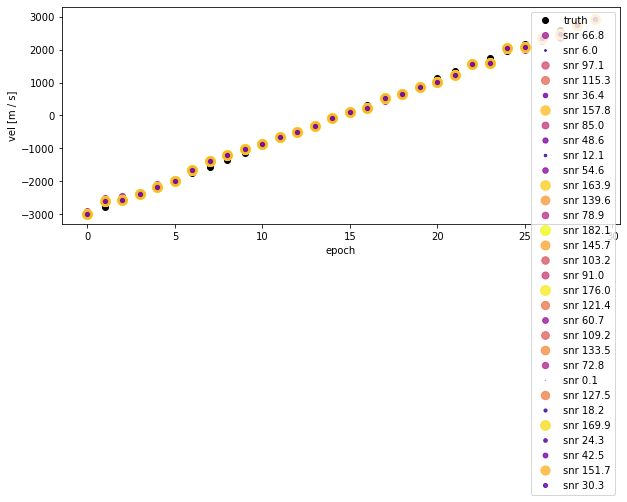

In [12]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
for i in range(len(files)):
    
    vmean  = np.mean(final_vels[i,:])
    v_unit = u.m/u.s
    plt.plot((final_vels[i,:] - vmean - init_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8,markersize=10*(snrs[i]/max(snrs))**(1/2))
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'),dpi=300)
plt.show()

0.6055234333740194
0.18225231950583604
0.7302945723949774
0.795818819755044
0.4471927193499168
0.9309483180509438
0.6831254724367491
0.5163887124888249
0.2580899714081882
0.5477131888629359
0.948681528680455
0.8755941781600012
0.6582746237876782
1.0
0.8944266104862175
0.7527689896755192
0.707103957680941
0.983192711298082
0.8164958506530733
0.5773420399605452
0.7745943920577707
0.8563457806642734
0.6324516697807054
0.022502464260804784
0.8366581495050911
0.31616840200875457
0.9660908653994537
0.36511168899782004
0.48303237129274373
0.9128712482191966
0.40822329876281344


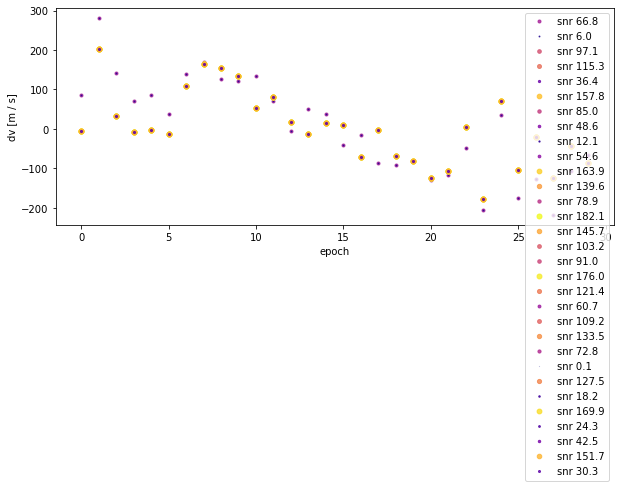

In [13]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s

# fig.colorbar(cm.plasma)
for i in range(len(files)):
    print((snrs[i]/max(snrs))**(1/2))
    v_unit = u.m/u.s
    plt.plot((final_vels[i,:] - vmean - rv).to(v_unit).value,'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8,markersize=10 * (snrs[i]/max(snrs))**(1/2))
    plt.ylabel('dv [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_rvs.png'),dpi=300)
plt.show()

<h2>Plotting Hours</h2>
Oh yea it's plottin' time

In [1]:
plt_i = 2
xpmin = np.log(7576.5)
xpmax = np.log(7578.5)
fig, axes = plt.subplots(len(datasets),figsize=(5,16),sharex=True,sharey=True,facecolor=(1,1,1))

plot_shift = 0.8

fig.suptitle('RV {:2.1f}'.format(rv[plt_i]))
indices = np.argsort(snrs)
for index,i in enumerate(indices):
#     i = index
    axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:]))+ 2 * plot_shift,'r',where='mid',alpha=0.5,label='stellar theory')
    axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]) + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')
    axes[index].step(datasets[i].xs[plt_i,:],datasets[i].ys[plt_i,:],'k',where='mid',label='data')
    axes[index].plot(models[i][1].xs-models[i][0].p[plt_i],models[i][1].p + 3 * plot_shift,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')
    axes[index].set_xlim(xpmin,xpmax)
    axes[index].set_ylim(-0.8,3.)
    axes[index].set_ylabel('snr {:2.1f}'.format(snrs[i]))
    
    
    res_ax = axes[index].twinx()
    residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))) * np.sqrt(datasets[i].yivar[plt_i,:])
    res_ax.step(datasets[i].xs[plt_i,:],residual,where='mid',alpha=0.3,label='residual')
    res_ax.set_xlim(xpmin,xpmax)
    res_ax.set_ylim(-1e2,1e2)
handles, labels = axes[0].get_legend_handles_labels()
res_handles, res_labels = res_ax.get_legend_handles_labels()
handles.append(*res_handles)
labels.append(*res_labels)
fig.legend(handles, labels)
plt.savefig(os.path.join(outdir,'flux_s_snrs_x{:2.1f}-{:2.1f}.png'.format(xpmin,xpmax)),dpi=300)
plt.show()

NameError: name 'np' is not defined

In [ ]:
plt_inds = 4
xpmin = np.log(7575)
xpmax = np.log(7580)
fig, axes = plt.subplots(plt_inds,figsize=(10,10),sharex=True,sharey=True,facecolor=(1,1,1))

dataset_i = 1
fig.suptitle('SNR {:2.1f}'.format(snrs[dataset_i]))
for j in range(plt_inds):        
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normal_flux(h5_data[dataset_i]['theory']['interpolated']['star']['flux'][j,:])),'r',where='mid',alpha=0.5,label='stellar theory')
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[dataset_i]['theory']['interpolated']['random']['flux'][j,:]) + 3.,'b',where='mid',alpha=0.5,label='tellurics theory')
    axes[j].step(datasets[dataset_i].xs[j,:],datasets[i].ys[j,:] + 1.,'k',where='mid',label='data')
    axes[j].plot(models[dataset_i][1].xs-models[dataset_i][0].p[j] + 2.,models[dataset_i][1].p,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')
    
    axes[j].set_xlim(xpmin,xpmax)
    axes[j].set_ylim(-1.2,5)
    axes[j].set_ylabel('RV {:1.0f}'.format(rv[j]))
    
    res_ax = axes[j].twinx()
    residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))) * np.sqrt(datasets[i].yivar[plt_i,:])
    res_ax.step(datasets[dataset_i].xs[j,:],residual,where='mid',alpha=0.2,label='residual')
    res_ax.set_xlim(xpmin,xpmax)
    res_ax.set_ylim(-1e2,1e2)
handles, labels = axes[0].get_legend_handles_labels()
res_handles, res_labels = res_ax.get_legend_handles_labels()
handles.append(*res_handles)
labels.append(*res_labels)
fig.legend(handles, labels)
    
plt.savefig(os.path.join(outdir,'flux_s_rvs_x{:2.1f}-{:2.1f}.png'.format(xpmin,xpmax)),dpi=300)
plt.show() 

In [ ]:
for i in range(len(datasets)):
#     print(jabble.dataset.velocities(models[i][0].p)[0])
    print(models[i][1].p[:3])

In [ ]:
rv[0].to(u.km/u.s), final_vels[0].to(u.km/u.s)

In [ ]:
(final_vels[0] - init_vels[0]).to(u.km/u.s), init_vels[0].to(u.km/u.s), final_vels[0].to(u.km/u.s)

In [ ]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
# plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='init')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0].p)
    
    v_unit = u.m/u.s
    plt.plot((final_vels - init_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.3)
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'),dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0].p)
    print(final_vels[0])
    v_unit = u.m/u.s
    plt.plot((final_vels - rv).to(v_unit).value,'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8,markersize=20*(snrs[i]/max(snrs)))
    plt.ylabel('dv [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_rvs.png'),dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4))
v_unit = u.m/u.s
# plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
# plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='truth')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0].p)
    
    v_unit = u.m/u.s
    plt.plot(abs((final_vels - rv)/rv),'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8)
    plt.ylabel('frac res'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
# plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'))
plt.show()

In [ ]:
for model in models:
    print(model.results)